# COMP90051 Project 2
**Name:** Diego Aranda Villarreal

**Student ID:** 992038

In [1]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from math import log
from sklearn.metrics import accuracy_score
import scipy

## 0. Loading the dataset

In [2]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

## 1. Applying logistic regression

In [3]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    model = LogisticRegression(multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C = args['C']) # Creating the Logistic Regression model
    return model.fit(X, y) # Return fit model

In [4]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    y_pred = model.predict(Xt) # Getting predictions
    acc = accuracy_score(yt, y_pred) # Calculating accuracies
    return acc

In [5]:
# your code here for training, evaluating & plotting results
seed_set_copy = seed_set.copy()
model = train_logistic_regression(X_pool, y_pool, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)
acc = evaluate_logistic_regression_accuracy(X_test, y_test, model) # Calling evaluate function to test the model
acc

0.6024896265560166

In [6]:
# This is the gold standard and the below models should aim to around 60% of accuracy while using the same parameters for the Logistic Regression model

## 2. Active learning framework with Random selection

In [7]:
def random_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    n,d = X.shape # Creating vector of size n as the number of samples in the current unlabelled dataset
    scores = np.random.choice(n, size=n, replace=False) # Generating random scores
    return scores

In [8]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    all_models = [] # Creating an array of Logistic Regression models
    all_ids = range(len(X_pool)) # Cresting array of ids
    while(len(seed_ids) < max_size): # Navigating through the max_size variable
        X_seed = X_pool[seed_ids] # Filtering pool with current ids
        y_seed = y_pool[seed_ids] # Filtering pool with current ids
        no_seed_ids = list(set(range(len(X_pool))) - set(seed_ids)) # Getting no seed ids
        X_unlabelled = X_pool[no_seed_ids] # Generating unlabelled set
        y_unlabelled = y_pool[no_seed_ids] # Generating unlabelled set     
        model = train_func(X_seed, y_seed, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C']) # Training the Logistic Regression model with the current seed_ids
        scores = select_func(X_unlabelled, model) # Calling scoring function to rank the X_unlabelled set    
        for i in range(batch_size): # Navigating through batches
            id = np.argmax(scores) # Getting max score
            scores = np.delete(scores, [id])
            seed_ids.append(id) # Add the current id to the id list  
        all_models.append(model) # Add the current trained model to the list of trained Logistic Regression models
    # Doing the final 46th step (start in T=0 and end in T=45 is 46 steps in total)
    model = train_func(X_seed, y_seed, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C'])
    all_models.append(model)
    return all_models

In [9]:
batch = 60
max_size = 3000
seed_set_copy = seed_set.copy()
models_random = pool_based_active_learning(X_pool, y_pool, seed_set_copy,
                                    train_logistic_regression, random_select, 
                                    max_size, batch, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)

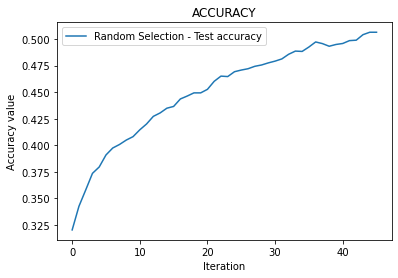

In [10]:
## your code here for evaluation of accuracy and plotting of results
acc_list_1 = []
Xt = X_test
yt = y_test
for i in range(len(models_random)):
    acc = evaluate_logistic_regression_accuracy(Xt, yt, models_random[i])
    acc_list_1.append(acc)

plt.plot(acc_list_1, label='Random Selection - Test accuracy')
plt.title('ACCURACY')
plt.ylabel('Accuracy value')
plt.xlabel('Iteration')
plt.legend(loc="upper left")
plt.show()

In [11]:
acc_list_1[45]

0.5064315352697095

In [12]:
# This result shows that using a batched active learning framework using a random selection heuristic achieves around 50% of accuracy. This result could be improved by using other techniques for selecting samples to reveal their labels to the model.

## 3. Uncertainty sampling

In [13]:
# This is another selection method as in random_select, but uses most predictive uncertainty under the model
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    entropy = -(model.predict_proba(X) * model.predict_log_proba(X)).sum(axis=1) # Schein and Ungar (2007)
    return entropy

In [14]:
batch = 60
max_size = 3000
seed_set_copy = seed_set.copy()
models_us = pool_based_active_learning(X_pool, y_pool, seed_set_copy, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)

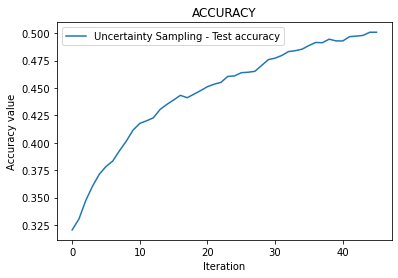

In [15]:
## your code here for evaluation of accuracy and plotting of results
acc_list_2 = []
Xt = X_test
yt = y_test
for i in range(len(models_us)):
    acc = evaluate_logistic_regression_accuracy(Xt, yt, models_us[i])
    acc_list_2.append(acc)

plt.plot(acc_list_2, label='Uncertainty Sampling - Test accuracy')
plt.title('ACCURACY')
plt.ylabel('Accuracy value')
plt.xlabel('Iteration')
plt.legend(loc="upper left")
plt.show()

In [16]:
acc_list_2[45]

0.5008298755186722

In [17]:
# The uncertainty sampling method for active learning was used to select instances that have the most predictive uncertainty under the model. It was expected for this model to be slightly better than using the random selection heuristic, however, it reached about the same result. A better result could be obtained and a difference between the two strategies could be made if using more instances.

## 4. Query by committee

In [18]:
num_class = np.unique(y_pool).shape[0] # Getting number of classes
class_label = np.unique(y_pool).tolist() # Getting a list of the classes

# don't forget to provide function descriptive comments, like those provided in templates above
# All of these formulas where done by following Settles p.29
def query_by_committee_vote_entropy(X, model_list, **args):
    num_model = len(model_list) # List of bagging models
    y_pred = [] # Empty list of predictions
    for model in model_list: # Navigating through models
        y_pred.append(model.predict(X)) # Append model predictions
    temp = np.transpose(np.vstack(y_pred)) # Temp[i] = predictions for instance i
    out_score = [] # Empty list of scores
    for i in range(X.shape[0]):
        prob = np.unique(temp[i], return_counts = True)[1]/num_model  # Extract count, ignore absent class(es), then divide by committee count
        out_score.append(scipy.stats.entropy(prob)) # Appending scores by entropy
    return out_score

def query_by_committee_soft_vote_entropy(X, model_list, **args):
    num_model = len(model_list) # List of bagging models
    y_prob = model_list[0].predict_proba(X) # Getting probability estimate of 1st model
    for model in model_list[1:]: # Going through model_list
        y_prob += model.predict_proba(X) # Getting the rest of probability estimates
    consensus_prob = y_prob/num_model # Calculating the consensus probability
    out_score = [] # Empty list for scores
    for i in range(len(consensus_prob)): # Going through consensus probabilities
        out_score.append(scipy.stats.entropy(consensus_prob[i])) # Appending scores by assessing entropy of consensus probabilities
    return out_score

def query_by_committee_KL(X, model_list, **args):
    num_model = len(model_list) # List of bagging models
    y_prob = [model_list[0].predict_proba(X)] # Getting probability estimate of 1st model
    consensus_prob = model_list[0].predict_proba(X) # Calculating the consensus probability
    for model in model_list[1:]: # Going through model_list
        y_prob.append(model.predict_proba(X)) # Append probability estimates
        consensus_prob += model.predict_proba(X) # Summing consensus probability
    consensus_prob = consensus_prob/num_model # Calculating the consensus probability
    out_score = []
    for i in range(X.shape[0]): # Navigating through current X instances
        temp_KL_div = [] # Empty list for KL divergence
        for j in range(num_model): # Going through each bagging model
            temp_KL_div.append(scipy.stats.entropy(y_prob[j][i], qk=consensus_prob[i])) # Appending KL divergence
        out_score.append(np.mean(temp_KL_div)) # Appending score for current instance
    return out_score

In [19]:
def train_committee(X_pool, y_pool, seed_ids,
                               select_func,
                               max_size, batch_size, **args):
    # This algorithm is doing a similar thing compared to pool_based_active_learning but it is including the bagging algorithm within it to make it work correctly, it works like a charm! I'm returning the accuracies list from this function in addition to the instances, which would be the main difference
    X_seed = np.array([X_pool[id] for id in seed_ids]) # Filtering pool with current ids
    y_seed = np.array([y_pool[id] for id in seed_ids]) # Filtering pool with current ids
    X_unlabelled = np.array([X_pool[i] for i in range(len(X_pool)) if i not in seed_ids]) # Generating unlabelled set
    y_unlabelled = np.array([y_pool[i] for i in range(len(y_pool)) if i not in seed_ids]) # Generating unlabelled set
    acc_list = [] # Empty list with accuracies
    while( X_seed.shape[0] < max_size ): # Navigating through the max_size variable
        model_single = train_logistic_regression(X_seed, y_seed, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C']) # Training the Logistic Regression model with the current seed_ids
        acc_score = evaluate_logistic_regression_accuracy(X_test, y_test, model_single) # Evaluate the model with current seeds
        acc_list.append(acc_score) # Append the accuracy of the current model
        bagging_1 = np.random.choice(list(range(len(X_seed))), len(X_seed)) # Get bagging instances 1
        X_seed_1 = X_seed[bagging_1] # Filter bagging instances 1
        y_seed_1 = y_seed[bagging_1] # Filter bagging instances 1
        bagging_2 = np.random.choice(list(range(len(X_seed))), len(X_seed)) # Get bagging instances 2
        X_seed_2 = X_seed[bagging_2] # Filter bagging instances 2
        y_seed_2 = y_seed[bagging_2] # Filter bagging instances 2
        model1 = train_logistic_regression(X_seed_1, y_seed_1, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C']) # Train bagging model 1
        model2 = train_logistic_regression(X_seed_2, y_seed_2, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C']) # Train bagging model 2
        scores = select_func(X_unlabelled, [model1, model2]) # Calling scoring function to rank the X_unlabelled
        scores_id = [(score, ida) for ida, score in enumerate(scores)] # Create a list of ids for the scores
        scores_id.sort(reverse=True) # Sort scores_id in descending order
        top_ids = [ida for _,ida in scores_id[:batch_size]] # Get top ids from batch size
        X_seed = np.concatenate((X_seed, X_unlabelled[top_ids])) # Add top ranked instances
        y_seed = np.concatenate((y_seed, y_unlabelled[top_ids])) # Add top ranked instances
        y_unlabelled = np.delete(y_unlabelled, top_ids, axis = 0) # Delete xj from unlabelled set
        X_unlabelled = np.delete(X_unlabelled, top_ids,axis = 0) # Delete yj from unlabelled set
    # Doing the final 46th step (start in T=0 and end in T=45 is 46 steps in total)
    model_single = train_logistic_regression(X_seed, y_seed, multi_class=args['multi_class'], solver=args['solver'], max_iter=args['max_iter'], C=args['C'])
    acc_score = evaluate_logistic_regression_accuracy(X_test, y_test, model_single)
    acc_list.append(acc_score)
    return X_seed, y_seed, acc_list

In [20]:
seed_set_copy = seed_set.copy()
X_hardvote, y_hardvote, acc_list_hardvote = train_committee(X_pool, y_pool, seed_set_copy,
                                    query_by_committee_vote_entropy, 
                                    max_size, batch, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)

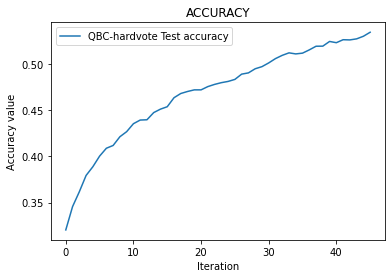

In [21]:
plt.plot(acc_list_hardvote, label='QBC-hardvote Test accuracy')
plt.title('ACCURACY')
plt.ylabel('Accuracy value')
plt.xlabel('Iteration')
plt.legend(loc="upper left")
plt.show()

In [22]:
acc_list_hardvote[45]

0.5343360995850622

In [23]:
# Using hardvote entropy got better results compared to uncertainty sampling and random selection. This strategy got the best results out of the three committee based measures of disagreement.

In [24]:
seed_set_copy = seed_set.copy()
X_softvote, y_softvote, acc_list_softvote = train_committee(X_pool, y_pool, seed_set_copy,
                                    query_by_committee_soft_vote_entropy, 
                                    max_size, batch, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)

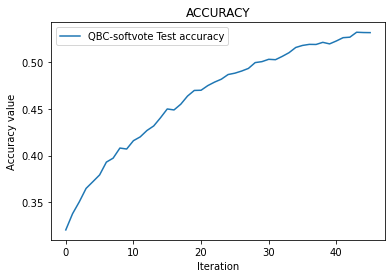

In [25]:
plt.plot(acc_list_softvote, label='QBC-softvote Test accuracy')
plt.title('ACCURACY')
plt.ylabel('Accuracy value')
plt.xlabel('Iteration')
plt.legend(loc="upper left")
plt.show()

In [26]:
acc_list_softvote[45]

0.5314315352697095

In [27]:
# Using softvote entropy got better results compared to uncertainty sampling and random selection.

In [28]:
seed_set_copy = seed_set.copy()
X_kl, y_kl, acc_list_kl = train_committee(X_pool, y_pool, seed_set_copy,
                                    query_by_committee_KL, 
                                    max_size, batch, multi_class='ovr', solver='liblinear', max_iter=2000, C=0.05)

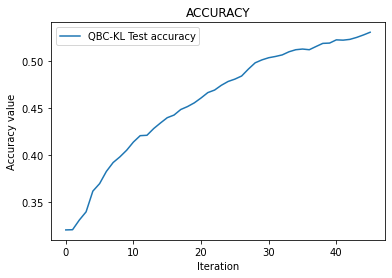

In [29]:
plt.plot(acc_list_kl, label='QBC-KL Test accuracy')
plt.title('ACCURACY')
plt.ylabel('Accuracy value')
plt.xlabel('Iteration')
plt.legend(loc="upper left")
plt.show()

In [30]:
acc_list_kl[45]

0.5303941908713693

In [31]:
# Using KL divergence got better results compared to uncertainty sampling and random selection.

In [32]:
# In general, using bagging with different measures of disagreement got a better results compared to uncertainty sampling and random selection of instances for the active learning task. I consider that bagging brings better results as it queries the most informative instances, which makes the model more stable, reducing the varaince and improving accuracy. Moreover, bagging was able to take several weak Logistic Regression models while aggregating their prediction and selecting the best predicions from those.

## 5. Hierarchical sampling

In [1]:
## your code